<a href="https://colab.research.google.com/github/cytronicoder/genebench-perturbseq/blob/main/final_embed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install scanpy anndata scikit-bio pingouin scikit-learn matplotlib pandas numpy scipy

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install obonet mygene networkx

FINAL CORRECTED BIOLOGICAL ANALYSIS
Loading GSE133344...
Loaded: 111445 cells × 33694 genes | gemgroups: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
Perturbation type distribution:
perturbation_type
single     57831
dual       41759
control    11855
Name: count, dtype: int64
Loading GeneRAIN from: /content/drive/MyDrive/dataset-gene-embed/GeneRAIN-vec.200d.txt
GeneRAIN: 31769 genes × 200 dims
Creating gemgroup-matched pseudobulks...
Created pseudobulk for 2037 guide×gemgroup combos
Computing gemgroup-matched effects...
Found 4 control guides
Computed effects for 268 guides
Target combinations for analysis: 268

--- Testing average ---
Missing genes in embeddings: 4 unique
Common guides: 262
Correlation: ρ=0.080  CI[0.069, 0.090]
P@10: 0.310 ± 0.217

--- Testing sum ---
Missing genes in embeddings: 4 unique
Common guides: 262
Correlation: ρ=0.080  CI[0.069, 0.090]
P@10: 0.310 ± 0.217

Best method: average
Missing genes in embe

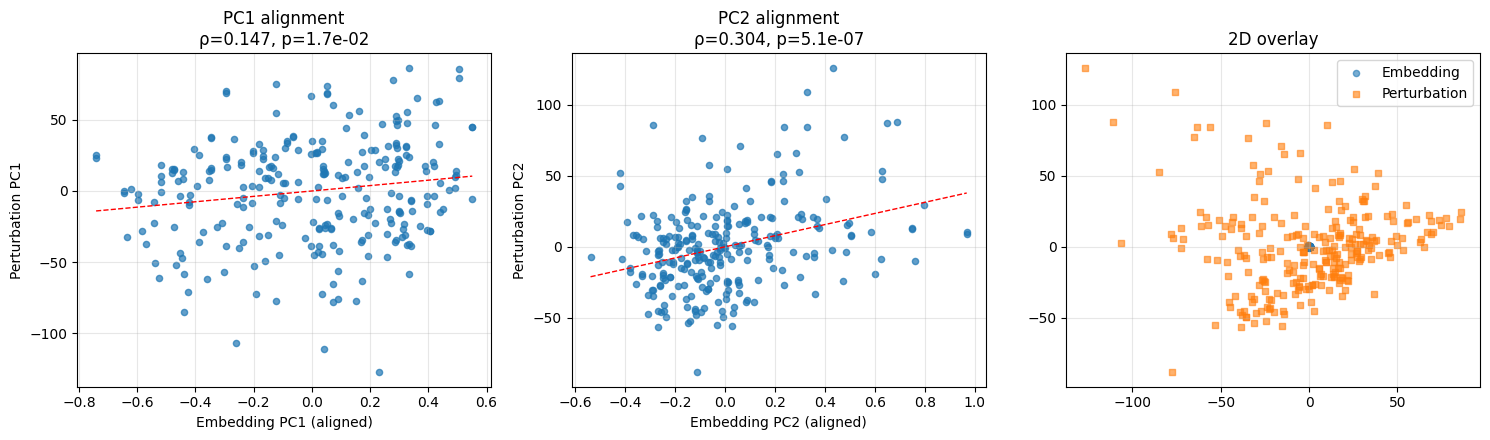

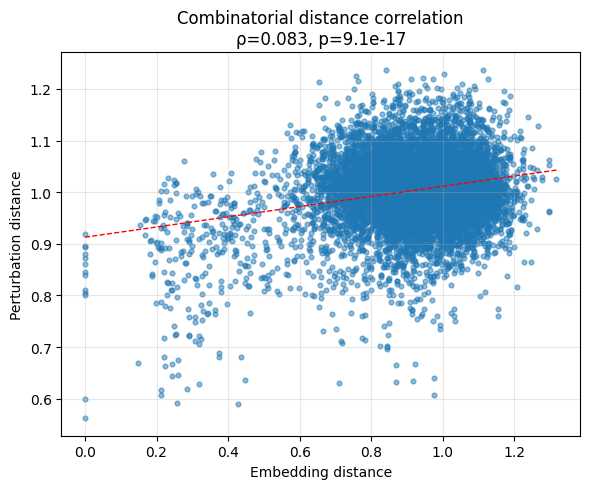

Single-gene: 100 unique genes


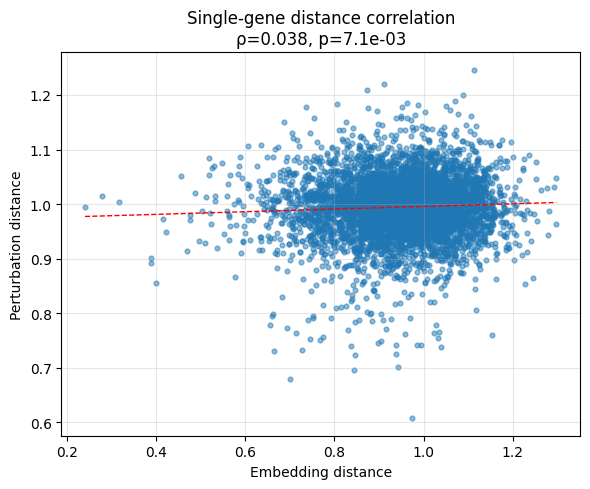

Saved: results/final_corrected_analysis.json

=== GO vs Perturbation / Embedding ===
Reading GO graph...


TypeError: 'float' object is not iterable

In [ ]:
# =========================
# FINAL CORRECTED ANALYSIS PIPELINE with GO semantic similarity
# =========================
# References:
# - Norman et al., Science (2019) combinatorial Perturb-seq (GSE133344)
# - GO semantic similarity (Resnik IC + BMA), GOSemSim methodology
# - go-basic.obo from the Gene Ontology; loaded with obonet
# - MyGene.info for human gene→GO annotations
# =========================

# If you're on Colab, uncomment:
# !pip -q install scanpy anndata scikit-bio pingouin scikit-learn matplotlib pandas numpy scipy \
#                  obonet mygene networkx

import os, json, gzip, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import scanpy as sc
import scipy.io
from scipy import sparse
from scipy.stats import spearmanr, mannwhitneyu, fisher_exact
from skbio.stats.distance import mantel, DistanceMatrix
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import KFold
from scipy.linalg import orthogonal_procrustes
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt

# GO imports
import obonet, networkx as nx
import mygene

# -------------------------
# File paths (edit to your drive)
# -------------------------
BASE = "/content/drive/MyDrive/dataset-gene-embed"
FILES = {
    "barcodes": f"{BASE}/GSE133344_filtered_barcodes.tsv.gz",
    "cell_id": f"{BASE}/GSE133344_filtered_cell_identities.csv.gz",
    "matrix":   f"{BASE}/GSE133344_filtered_matrix.mtx",
    "genes":    f"{BASE}/GSE133344_filtered_genes.tsv",
    "generain": f"{BASE}/GeneRAIN-vec.200d.txt",
}
os.makedirs("results", exist_ok=True)
os.makedirs("figs", exist_ok=True)

# =========================
# JSON helpers (fix ndarray errors)
# =========================
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, (np.integer, np.floating)): return obj.item()
        if isinstance(obj, np.ndarray): return obj.tolist()
        if isinstance(obj, (pd.Series, pd.DataFrame)): return obj.to_dict()
        return super().default(obj)

def json_safe(obj):
    if isinstance(obj, dict): return {k: json_safe(v) for k, v in obj.items()}
    if isinstance(obj, list): return [json_safe(v) for v in obj]
    if isinstance(obj, (np.integer, np.floating)): return obj.item()
    if isinstance(obj, np.ndarray): return obj.tolist()
    if hasattr(obj, 'to_dict'): return json_safe(obj.to_dict())
    return obj

# =========================
# Load Norman 2019 (GSE133344)
# =========================
def load_gse133344():
    print("Loading GSE133344...")
    genes = pd.read_csv(FILES["genes"], sep="\t", header=None, names=["ensembl_id","gene_symbol"])
    with gzip.open(FILES["barcodes"], "rt") as f:
        barcodes = [ln.strip() for ln in f]
    cell_id = pd.read_csv(FILES["cell_id"], compression="gzip")
    X = scipy.io.mmread(FILES["matrix"]).T.tocsr()

    ad = sc.AnnData(X=X)
    ad.obs_names = barcodes
    ad.var_names = genes["gene_symbol"].values
    ad.var["ensembl_id"] = genes["ensembl_id"].values
    ad.var_names_make_unique()

    cell_id = cell_id.set_index("cell_barcode")
    common = list(set(ad.obs_names) & set(cell_id.index))
    ad = ad[common].copy()
    ad.obs = ad.obs.join(cell_id.loc[common])

    print(f"Loaded: {ad.n_obs} cells × {ad.n_vars} genes | gemgroups: {sorted(ad.obs['gemgroup'].unique())}")
    return ad

def parse_combinatorial_targets(guide_identity):
    if pd.isna(guide_identity): return []
    target_part = guide_identity.split('__')[0]
    comps = [c for c in target_part.split('_') if c and 'NegCtrl' not in c]
    # unique, keep order
    seen, out = set(), []
    for g in comps:
        if g not in seen: out.append(g); seen.add(g)
    return out

def categorize_perturbations(ad):
    ad.obs['parsed_targets'] = ad.obs['guide_identity'].apply(parse_combinatorial_targets)
    ad.obs['n_targets'] = ad.obs['parsed_targets'].apply(len)
    ad.obs['perturbation_type'] = 'unknown'
    ad.obs.loc[ad.obs['n_targets'] == 0, 'perturbation_type'] = 'control'
    ad.obs.loc[ad.obs['n_targets'] == 1, 'perturbation_type'] = 'single'
    ad.obs.loc[ad.obs['n_targets'] == 2, 'perturbation_type'] = 'dual'
    ad.obs.loc[ad.obs['n_targets'] > 2, 'perturbation_type'] = 'multi'
    print("Perturbation type distribution:")
    print(ad.obs['perturbation_type'].value_counts())
    return ad

def load_generain_embeddings(path):
    print(f"Loading GeneRAIN from: {path}")
    genes, embeds = [], []
    with open(path, "r") as f:
        _ = f.readline().strip()
        for ln in f:
            parts = ln.strip().split()
            if len(parts) < 2: continue
            genes.append(parts[0])
            embeds.append([float(x) for x in parts[1:]])
    df = pd.DataFrame(embeds, index=pd.Index(genes, name="gene"))
    df.columns = [f"generain_{i}" for i in range(df.shape[1])]
    df = df[~df.index.duplicated(keep="first")]
    print(f"GeneRAIN: {df.shape[0]} genes × {df.shape[1]} dims")
    return df

# =========================
# Pseudobulk & effects
# =========================
def make_gemgroup_matched_combinatorial_pseudobulk(ad, min_cells=20):
    print("Creating gemgroup-matched pseudobulks...")
    groups = ad.obs.groupby(['guide_identity', 'gemgroup']).indices
    rows, meta = [], []
    X = ad.X
    is_sparse = sparse.issparse(X)
    for (guide, gem), idx in groups.items():
        if len(idx) < min_cells: continue
        summed = np.array(X[idx].sum(axis=0)).ravel() if is_sparse else X[idx].sum(axis=0)
        rows.append(summed)
        meta.append({
            'guide_identity': guide,
            'gemgroup': gem,
            'n_cells': len(idx),
            'targets': ad.obs.loc[ad.obs_names[idx[0]], 'parsed_targets'],
            'perturbation_type': ad.obs.loc[ad.obs_names[idx[0]], 'perturbation_type']
        })
    pb = pd.DataFrame(rows, columns=ad.var_names)
    pb.index = pd.MultiIndex.from_frame(pd.DataFrame(meta)[['guide_identity','gemgroup']])
    meta_df = pd.DataFrame(meta)
    print(f"Created pseudobulk for {len(pb)} guide×gemgroup combos")
    return pb, meta_df

def compute_gemgroup_matched_combinatorial_effects(pseudobulk_df, meta_df):
    print("Computing gemgroup-matched effects...")
    lib = pseudobulk_df.sum(axis=1)
    cpm = pseudobulk_df.div(lib, axis=0) * 1e6
    logcpm = np.log1p(cpm)

    control_guides = set(meta_df[meta_df['perturbation_type']=='control']['guide_identity'])
    print(f"Found {len(control_guides)} control guides")
    all_guides = sorted(set(meta_df['guide_identity']))
    target_guides = [g for g in all_guides if g not in control_guides]

    effects = {}
    for guide in target_guides:
        try:
            gp = logcpm.loc[guide]
            if isinstance(gp, pd.Series):
                gp = pd.DataFrame([gp.values], index=[gp.name], columns=logcpm.columns)
            geffs = []
            for gem in gp.index:
                ctrls = []
                for c in control_guides:
                    try: ctrls.append(logcpm.loc[(c, gem)])
                    except KeyError: pass
                if ctrls:
                    ctrlmean = ctrls[0] if len(ctrls)==1 else pd.concat(ctrls, axis=1).mean(axis=1)
                    geffs.append(gp.loc[gem] - ctrlmean)
            if geffs:
                mean_eff = geffs[0] if len(geffs)==1 else pd.concat(geffs, axis=1).mean(axis=1)
                effects[guide] = mean_eff.values
        except KeyError:
            continue
    eff = pd.DataFrame.from_dict(effects, orient='index', columns=logcpm.columns)
    # z-score across guides
    mu = eff.mean(axis=0); sd = eff.std(axis=0, ddof=0).replace(0, 1.0)
    z = eff.subtract(mu, axis=1).divide(sd, axis=1)
    z = z.replace([np.inf, -np.inf], 0).fillna(0)
    print(f"Computed effects for {len(z)} guides")
    return z

# =========================
# Embeddings, distances, stats
# =========================
def create_combined_embeddings_multi_method(target_combinations, generain_embeddings, method='average'):
    out, missing = {}, set()
    for combo, genes in target_combinations.items():
        if len(genes)==0:
            out[combo] = np.zeros(generain_embeddings.shape[1])
            continue
        avail = [g for g in genes if g in generain_embeddings.index]
        missing.update(set(genes)-set(avail))
        if not avail: continue
        M = np.stack([generain_embeddings.loc[g].values for g in avail])
        if method=='average': out[combo] = M.mean(axis=0)
        elif method=='sum':  out[combo] = M.sum(axis=0)
        elif method=='hadamard': out[combo] = M.prod(axis=0)
    if missing: print(f"Missing genes in embeddings: {len(missing)} unique")
    return pd.DataFrame.from_dict(out, orient='index')

def pairwise_cosine(M):
    M = np.nan_to_num(M, nan=0.0, posinf=1.0, neginf=-1.0)
    norms = np.linalg.norm(M, axis=1)
    zero = norms==0
    if zero.any():
        M[zero] += np.random.normal(0, 1e-6, size=(zero.sum(), M.shape[1]))
    D = pairwise_distances(M, metric='cosine')
    np.fill_diagonal(D, 0.0)
    return np.nan_to_num(D, nan=1.0, posinf=1.0, neginf=0.0)

def compute_per_gene_concordance(Dg, Dp, gene_names):
    n = len(gene_names); rows=[]
    for i,g in enumerate(gene_names):
        mask = np.ones(n, bool); mask[i]=False
        x, y = Dg[i,mask], Dp[i,mask]
        valid = ~(np.isnan(x)|np.isnan(y)|np.isinf(x)|np.isinf(y))
        if valid.sum()<5: rows.append((g,0.0,1.0)); continue
        r, p = spearmanr(x[valid], y[valid])
        rows.append((g, float(0 if np.isnan(r) else r), float(1 if np.isnan(p) else p)))
    df = pd.DataFrame(rows, columns=['gene','rho','p']).set_index('gene')
    df['q'] = multipletests(df['p'], method='fdr_bh')[1]
    return df.sort_values('rho', ascending=False)

def comprehensive_validation_analysis(Dg, Dp, gene_names, n_bootstrap=1000):
    iu = np.triu_indices_from(Dg, k=1)
    x, y = Dg[iu], Dp[iu]
    valid = ~(np.isnan(x)|np.isnan(y)|np.isinf(x)|np.isinf(y))
    x, y = x[valid], y[valid]
    if len(x)==0: return {"error":"no_valid_pairs"}
    rho, p = spearmanr(x, y)
    boot = []
    rng = np.random.default_rng(42)
    for _ in range(n_bootstrap):
        idx = rng.integers(0, len(x), len(x))
        r,_ = spearmanr(x[idx], y[idx])
        if not np.isnan(r): boot.append(r)
    lo, hi = np.percentile(boot, [2.5, 97.5]) if boot else (np.nan,np.nan)
    # simple P@10
    n = Dg.shape[0]; Dg2, Dp2 = Dg.copy(), Dp.copy()
    np.fill_diagonal(Dg2, np.inf); np.fill_diagonal(Dp2, np.inf)
    p10=[]
    for i in range(n):
        rg=np.argsort(Dg2[i])[:10]; rp=np.argsort(Dp2[i])[:10]
        p10.append(len(set(rg)&set(rp))/10)
    return {
        'spearman_rho': float(rho),
        'spearman_p': float(p),
        'confidence_interval': [float(lo), float(hi)],
        'precision_at_10_mean': float(np.mean(p10)),
        'precision_at_10_std': float(np.std(p10)),
        'n_valid_pairs': int(len(x)),
        'n_genes': int(len(gene_names))
    }

# =========================
# Single-gene extraction & optional CCA-CV
# =========================
def extract_single_gene_data(effects_df, embeddings_df, guide_list):
    sg_guides, sg_genes = [], []
    for guide in guide_list:
        genes = [g for g in guide.split("__")[0].split("_") if g and "NegCtrl" not in g]
        if len(genes)==1:
            sg_guides.append(guide); sg_genes.append(genes[0])
    if not sg_guides: return None, None, []
    eff_sg = effects_df.loc[sg_guides].copy()
    emb_sg = embeddings_df.loc[sg_guides].copy()
    eff_sg.index = sg_genes; emb_sg.index = sg_genes
    # de-duplicate genes
    dedup = ~pd.Index(sg_genes).duplicated()
    eff_g = eff_sg.loc[dedup]; emb_g = emb_sg.loc[dedup]
    print(f"Single-gene: {eff_g.shape[0]} unique genes")
    return eff_g, emb_g, eff_g.index.tolist()

def cca_holdout_scores(X, Y, n_components=1, n_splits=5, scale=True, random_state=42):
    if not X.index.equals(Y.index): raise ValueError("X,Y must have same genes in the same order")
    Xv, Yv = X.values.copy(), Y.values.copy()
    if scale:
        Xv=(Xv-Xv.mean(0,keepdims=True))/(Xv.std(0,ddof=0,keepdims=True)+1e-8)
        Yv=(Yv-Yv.mean(0,keepdims=True))/(Yv.std(0,ddof=0,keepdims=True)+1e-8)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    rhos=[]
    for tr,te in kf.split(Xv):
        if len(tr)<=n_components or len(te)<5: continue
        try:
            cca=CCA(n_components=n_components, max_iter=500).fit(Xv[tr], Yv[tr])
            Xc,Yc=cca.transform(Xv[te], Yv[te])
            r,_=spearmanr(Xc[:,0], Yc[:,0])
            if not np.isnan(r): rhos.append(float(r))
        except Exception as e:
            print("CCA fold failed:", e)
    return {"mean_rho_test": float(np.mean(rhos)) if rhos else 0.0,
            "std_rho_test": float(np.std(rhos)) if rhos else 0.0,
            "fold_rhos": rhos, "n_successful_folds": len(rhos)}

# =========================
# GO semantic similarity (Resnik + BMA)
# =========================
def load_go_graph(go_obo_path="go-basic.obo"):
    """Download go-basic.obo if missing and parse into a DAG."""
    if not os.path.exists(go_obo_path):
        import urllib.request
        print("Downloading go-basic.obo ...")
        urllib.request.urlretrieve(
            "http://purl.obolibrary.org/obo/go/go-basic.obo", go_obo_path
        )
    print("Reading GO graph...")
    G = obonet.read_obo(go_obo_path)
    # Keep only 'is_a' edges; obonet already encodes relations as edges
    return G

def fetch_gene_go_bp_annotations(genes):
    """Use MyGene.info to fetch GO Biological Process terms for each HGNC symbol."""
    mg = mygene.MyGeneInfo()
    q = mg.querymany(genes, scopes='symbol', fields='go.BP', species='human', as_dataframe=True, df_index=True, returnall=False, verbose=False)
    go_map = {}
    for gene in genes:
        terms = set()
        if gene in q.index:
            rec = q.loc[gene]
            vals = []
            if isinstance(rec, pd.Series):
                vals = rec.get('go.BP', [])
            else:
                # if multiple rows returned, combine
                for _,row in rec.iterrows():
                    v = row.get('go.BP', [])
                    if isinstance(v, list): vals.extend(v)
                    elif isinstance(v, dict): vals.append(v)
            if isinstance(vals, dict): vals=[vals]
            for v in vals or []:
                tid = v.get('id') if isinstance(v, dict) else None
                if tid: terms.add(tid)
        go_map[gene] = terms
    return go_map

def compute_information_content(go_graph, gene_to_terms):
    """IC(term) = -log( freq(term or descendants) / total_genes )"""
    # propagate terms up the DAG
    term_counts = {}
    all_terms = set()
    for terms in gene_to_terms.values():
        all_terms |= set(terms)
    # ancestors incl. self
    def ancestors_incl(term):
        return {term} | nx.ancestors(go_graph, term) if term in go_graph else {term}
    # count genes annotated to each term (including propagation)
    term_gene_sets = {}
    for gene, terms in gene_to_terms.items():
        prop_terms = set()
        for t in terms:
            prop_terms |= ancestors_incl(t)
        for t in prop_terms:
            term_gene_sets.setdefault(t, set()).add(gene)
    for t, s in term_gene_sets.items():
        term_counts[t] = len(s)
    N = len(gene_to_terms)
    IC = {}
    for t, c in term_counts.items():
        p = max(c, 1) / N
        IC[t] = -np.log(p)
    maxIC = max(IC.values()) if IC else 1.0
    return IC, maxIC

def resnik_sim(term_a, term_b, G, IC):
    """Resnik similarity between two terms."""
    if term_a not in G or term_b not in G: return 0.0
    anc_a = {term_a} | nx.ancestors(G, term_a)
    anc_b = {term_b} | nx.ancestors(G, term_b)
    common = anc_a & anc_b
    if not common: return 0.0
    return max(IC.get(t, 0.0) for t in common)

def bma_gene_sim(terms_A, terms_B, G, IC):
    """Best-Match Average (symmetric) of Resnik across term sets."""
    if not terms_A or not terms_B: return 0.0
    # A→B
    s1 = [max(resnik_sim(a, b, G, IC) for b in terms_B) for a in terms_A]
    # B→A
    s2 = [max(resnik_sim(b, a, G, IC) for a in terms_A) for b in terms_B]
    return (np.mean(s1) + np.mean(s2)) / 2.0

def gene_gene_go_distance(genes, gene_to_terms, G, IC, maxIC):
    """Return a GO distance matrix using Resnik-BMA similarities (normalized)."""
    n = len(genes)
    S = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(i, n):
            sim = bma_gene_sim(gene_to_terms.get(genes[i], set()),
                               gene_to_terms.get(genes[j], set()), G, IC)
            # normalize by maxIC to [0,1]
            sim_norm = sim / maxIC if maxIC>0 else 0.0
            S[i,j] = S[j,i] = sim_norm
    # distance = 1 - similarity
    return 1.0 - S, S

def run_go_vs_perturbation(effects_genes, embeddings_genes):
    """
    Compare GO distance with (a) embedding distance and (b) perturbation distance.
    Uses single-gene subset (index are gene symbols).
    """
    print("\n=== GO vs Perturbation / Embedding ===")
    genes = list(effects_genes.index)
    # Build GO DAG + annotations
    G = load_go_graph()
    gene_to_terms = fetch_gene_go_bp_annotations(genes)
    IC, maxIC = compute_information_content(G, gene_to_terms)

    # Matrices
    D_go, S_go = gene_gene_go_distance(genes, gene_to_terms, G, IC, maxIC)
    D_emb = pairwise_cosine(embeddings_genes.loc[genes].values)
    D_eff = pairwise_cosine(effects_genes.loc[genes].values)

    # Correlations on upper triangles
    def tri_corr(A,B):
        iu = np.triu_indices_from(A, k=1)
        a, b = A[iu], B[iu]
        ok = ~(np.isnan(a)|np.isnan(b)|np.isinf(a)|np.isinf(b))
        return spearmanr(a[ok], b[ok])

    r_go_eff, p_go_eff = tri_corr(D_go, D_eff)   # ontology distance vs perturbation distance
    r_go_emb, p_go_emb = tri_corr(D_go, D_emb)   # ontology distance vs embedding distance
    r_emb_eff, p_emb_eff = tri_corr(D_emb, D_eff)

    print(f"GO distance ↔ Perturbation distance: ρ={r_go_eff:.3f}, p={p_go_eff:.2e}")
    print(f"GO distance ↔ Embedding distance:    ρ={r_go_emb:.3f}, p={p_go_emb:.2e}")
    print(f"Embedding distance ↔ Perturbation:    ρ={r_emb_eff:.3f}, p={p_emb_eff:.2e}")

    # Plots
    def dd_plot(Dx, Dy, title, fname):
        iu = np.triu_indices_from(Dx, 1)
        x, y = Dx[iu], Dy[iu]
        ok = ~(np.isnan(x)|np.isnan(y)|np.isinf(x)|np.isinf(y))
        x, y = x[ok], y[ok]
        if len(x)>10000:
            sel = np.random.choice(len(x), 10000, replace=False)
            x, y = x[sel], y[sel]
        r,p = spearmanr(x,y)
        plt.figure(figsize=(5.5,5))
        plt.scatter(x,y, s=10, alpha=0.5)
        z = np.polyfit(x,y,1); pfit = np.poly1d(z)
        xs = np.linspace(x.min(), x.max(), 200)
        plt.plot(xs, pfit(xs), 'r--', lw=1)
        plt.xlabel('X distance'); plt.ylabel('Y distance')
        plt.title(f"{title}\nρ={r:.3f}, p={p:.1e}")
        plt.grid(alpha=0.3); plt.tight_layout()
        os.makedirs("figs", exist_ok=True)
        plt.savefig(f"figs/{fname}.png", dpi=180, bbox_inches='tight')
        plt.show()

    dd_plot(D_go, D_eff, "GO distance vs Perturbation distance", "go_vs_perturbation")
    dd_plot(D_go, D_emb, "GO distance vs Embedding distance", "go_vs_embedding")
    dd_plot(D_emb, D_eff, "Embedding vs Perturbation distance", "embedding_vs_perturbation")

    results = {
        "n_genes": len(genes),
        "go_vs_perturbation": {"rho": float(r_go_eff), "p": float(p_go_eff)},
        "go_vs_embedding": {"rho": float(r_go_emb), "p": float(p_go_emb)},
        "embedding_vs_perturbation": {"rho": float(r_emb_eff), "p": float(p_emb_eff)}
    }
    with open("results/go_vs_perturbation.json","w") as f:
        json.dump(results, f, cls=NumpyEncoder, indent=2)
    print("Saved: results/go_vs_perturbation.json")
    return results, {"D_go": D_go, "D_emb": D_emb, "D_eff": D_eff, "S_go": S_go, "genes": genes}

# =========================
# Visualization (Procrustes + distance–distance)
# =========================
def create_distance_scatter_plot(Dg, Dp, title="Distance Correlation", fname="dist_corr"):
    iu = np.triu_indices_from(Dg, 1)
    x, y = Dg[iu], Dp[iu]
    ok = ~(np.isnan(x)|np.isnan(y)|np.isinf(x)|np.isinf(y))
    x, y = x[ok], y[ok]
    if len(x)>10000:
        idx = np.random.choice(len(x), 10000, replace=False)
        x, y = x[idx], y[idx]
    rho, p = spearmanr(x, y)
    plt.figure(figsize=(6,5))
    plt.scatter(x, y, alpha=0.5, s=12)
    z = np.polyfit(x,y,1); pfit = np.poly1d(z)
    xs = np.linspace(x.min(), x.max(), 200)
    plt.plot(xs, pfit(xs), "r--", lw=1)
    plt.xlabel("Embedding distance"); plt.ylabel("Perturbation distance")
    plt.title(f"{title}\nρ={rho:.3f}, p={p:.1e}")
    plt.grid(alpha=0.3); plt.tight_layout()
    plt.savefig(f"figs/{fname}.png", dpi=180, bbox_inches='tight'); plt.show()

def procrustes_alignment_plots(embeddings_aligned, effects_aligned, prefix="combinatorial"):
    pca_emb, pca_eff = PCA(2, random_state=42), PCA(2, random_state=42)
    Xe, Xp = pca_emb.fit_transform(embeddings_aligned.values), pca_eff.fit_transform(effects_aligned.values)
    R,_ = orthogonal_procrustes(Xe, Xp); Xe_al = Xe @ R
    fig, axes = plt.subplots(1,3, figsize=(15,4.5))
    for k, ax in enumerate(axes[:2]):
        r,p = spearmanr(Xe_al[:,k], Xp[:,k])
        ax.scatter(Xe_al[:,k], Xp[:,k], s=20, alpha=0.7)
        z = np.polyfit(Xe_al[:,k], Xp[:,k], 1); pf = np.poly1d(z)
        xs = np.linspace(Xe_al[:,k].min(), Xe_al[:,k].max(), 200); ax.plot(xs, pf(xs), "r--", lw=1)
        ax.set_xlabel(f'Embedding PC{k+1} (aligned)'); ax.set_ylabel(f'Perturbation PC{k+1}')
        ax.set_title(f'PC{k+1} alignment\nρ={r:.3f}, p={p:.1e}'); ax.grid(alpha=0.3)
    axes[2].scatter(Xe_al[:,0], Xe_al[:,1], s=20, alpha=0.6, label='Embedding')
    axes[2].scatter(Xp[:,0], Xp[:,1], s=20, alpha=0.6, label='Perturbation', marker='s')
    axes[2].set_title('2D overlay'); axes[2].legend(); axes[2].grid(alpha=0.3)
    plt.tight_layout(); os.makedirs("figs", exist_ok=True)
    plt.savefig(f"figs/{prefix}_procrustes.png", dpi=180, bbox_inches='tight'); plt.show()
    return {"pc_var_emb": pca_emb.explained_variance_ratio_,
            "pc_var_eff": pca_eff.explained_variance_ratio_}

# =========================
# Main runner
# =========================
def run_final_corrected_analysis():
    print("="*80); print("FINAL CORRECTED BIOLOGICAL ANALYSIS"); print("="*80)

    ad = load_gse133344()
    ad = categorize_perturbations(ad)
    generain = load_generain_embeddings(FILES['generain'])

    pb, meta = make_gemgroup_matched_combinatorial_pseudobulk(ad, min_cells=20)
    effects = compute_gemgroup_matched_combinatorial_effects(pb, meta)

    # mapping: guide -> list of targets
    target_combos = {}
    for _,row in meta.iterrows():
        g = row['guide_identity']
        if g in effects.index: target_combos[g] = row['targets']
    print(f"Target combinations for analysis: {len(target_combos)}")

    best_method, best_rho, method_results = None, -1, {}
    for method in ['average', 'sum']:
        print(f"\n--- Testing {method} ---")
        emb = create_combined_embeddings_multi_method(target_combos, generain, method=method)
        common = sorted(set(effects.index) & set(emb.index))
        print("Common guides:", len(common))
        if len(common)<20: continue
        eff_al = effects.loc[common]; emb_al = emb.loc[common]
        Dp = pairwise_cosine(eff_al.values); Dg = pairwise_cosine(emb_al.values)
        val = comprehensive_validation_analysis(Dg, Dp, common)
        method_results[method] = val
        print(f"Correlation: ρ={val['spearman_rho']:.3f}  CI[{val['confidence_interval'][0]:.3f}, {val['confidence_interval'][1]:.3f}]")
        print(f"P@10: {val['precision_at_10_mean']:.3f} ± {val['precision_at_10_std']:.3f}")
        if val['spearman_rho']>best_rho: best_rho, best_method = val['spearman_rho'], method

    print(f"\nBest method: {best_method}")
    # Rebuild for best method
    emb_best = create_combined_embeddings_multi_method(target_combos, generain, method=best_method)
    common = sorted(set(effects.index) & set(emb_best.index))
    eff_al = effects.loc[common]; emb_al = emb_best.loc[common]
    Dp_final = pairwise_cosine(eff_al.values); Dg_final = pairwise_cosine(emb_al.values)

    # Procrustes & scatter
    procrustes_alignment_plots(emb_al, eff_al, prefix="combinatorial")
    create_distance_scatter_plot(Dg_final, Dp_final, "Combinatorial distance correlation", "combinatorial_distance")

    # Single-gene subset
    eff_genes, emb_genes, uniq_genes = extract_single_gene_data(eff_al, emb_al, common)
    single_gene = {}
    if eff_genes is not None and len(uniq_genes)>=20:
        Dp_g = pairwise_cosine(eff_genes.values); Dg_g = pairwise_cosine(emb_genes.values)
        sg_val = comprehensive_validation_analysis(Dg_g, Dp_g, uniq_genes)
        sg_conc = compute_per_gene_concordance(Dg_g, Dp_g, uniq_genes)
        try:
            cca_cv = cca_holdout_scores(emb_genes, eff_genes, n_components=1, n_splits=5)
        except Exception as e:
            print("CCA-CV failed:", e); cca_cv=None
        single_gene = {
            "n_genes": len(uniq_genes),
            "validation": sg_val,
            "per_gene_concordance_top10": sg_conc.head(10),
            "cca_cv": cca_cv
        }
        create_distance_scatter_plot(Dg_g, Dp_g, "Single-gene distance correlation", "single_gene_distance")
    else:
        print("Insufficient single-gene data (need >=20).")

    # Save summary
    final_results = {
        "analysis_type": "final_corrected_analysis",
        "best_embedding_method": best_method,
        "combinatorial": json_safe(method_results[best_method]),
        "single_gene": json_safe(single_gene),
    }
    with open("results/final_corrected_analysis.json","w") as f:
        json.dump(final_results, f, cls=NumpyEncoder, indent=2)
    print("Saved: results/final_corrected_analysis.json")

    return final_results, {
        "effects_aligned": eff_al, "embeddings_aligned": emb_al,
        "Dg_final": Dg_final, "Dp_final": Dp_final,
        "effects_genes": eff_genes, "embeddings_genes": emb_genes
    }

# -------------------------
# Run now? (set True to execute immediately)
# -------------------------
RUN_NOW = True
if RUN_NOW:
    final_results, final_data = run_final_corrected_analysis()
    if final_data["effects_genes"] is not None:
        go_results, go_data = run_go_vs_perturbation(final_data["effects_genes"],
                                                     final_data["embeddings_genes"])

# Helper: if you ran earlier and just want GO analysis:
# go_results, go_data = run_go_vs_perturbation(effects_genes, embeddings_genes)


In [ ]:
# =========================
# GO ↔ Perturb-seq ↔ Embedding analysis (robust, NaN-safe)
# =========================
import os, json, math, gzip, itertools, urllib.request
import numpy as np
import pandas as pd
import networkx as nx

# Install when needed:
# !pip -q install mygene obonet

import mygene
import obonet
from sklearn.metrics import pairwise_distances
from scipy.stats import spearmanr

# ---------- Helpers: JSON ----------
def _json_safe(x):
    if isinstance(x, (np.integer, np.floating)): return x.item()
    if isinstance(x, np.ndarray): return x.tolist()
    if isinstance(x, (list, tuple)): return [_json_safe(v) for v in x]
    if isinstance(x, dict): return {k: _json_safe(v) for k, v in x.items()}
    if hasattr(x, "to_dict"): return _json_safe(x.to_dict())
    return x

# ---------- 1) Load GO DAG (go-basic.obo) ----------
def load_go_basic_obo(path="go-basic.obo"):
    """Download once and parse with obonet → networkx.DiGraph (DAG)."""
    if not os.path.exists(path):
        url = "http://purl.obolibrary.org/obo/go/go-basic.obo"
        print("Downloading go-basic.obo ...")
        urllib.request.urlretrieve(url, path)
    print("Reading GO graph...")
    G = obonet.read_obo(path)
    # Ensure edges go parent->child as in obonet; we will use ancestors() accordingly.
    return G

# ---------- 2) Fetch BP annotations from MyGene (NaN-safe) ----------
def fetch_gene_go_bp_annotations(genes, species="human", chunk=1000, verbose=True):
    """
    Returns dict: {gene_symbol -> set([GO:...])} for Biological Process.
    Uses as_dataframe=False to avoid NaN floats and heterogenous frames.
    """
    mg = mygene.MyGeneInfo()
    genes = [str(g) for g in genes]
    out = {g: set() for g in genes}

    for i in range(0, len(genes), chunk):
        batch = genes[i:i+chunk]
        resp = mg.querymany(
            batch, scopes="symbol", fields="go.BP", species=species,
            as_dataframe=False, returnall=False, verbose=False
        )
        # resp is a list of dict records
        for rec in resp:
            q = rec.get("query") or rec.get("symbol")
            if not q or q not in out:
                continue
            go_obj = (rec.get("go") or {})
            bp = go_obj.get("BP")
            # Accept list / dict / str, ignore others
            if isinstance(bp, list):
                for v in bp:
                    tid = v.get("id") if isinstance(v, dict) else (v if isinstance(v, str) else None)
                    if tid: out[q].add(tid if tid.startswith("GO:") else f"GO:{tid}")
            elif isinstance(bp, dict):
                tid = bp.get("id")
                if tid: out[q].add(tid if tid.startswith("GO:") else f"GO:{tid}")
            elif isinstance(bp, str):
                out[q].add(bp if bp.startswith("GO:") else f"GO:{bp}")
            # else: None / NaN / unexpected → skip
    if verbose:
        n_with = sum(1 for s in out.values() if len(s) > 0)
        print(f"Annotated (BP) genes: {n_with}/{len(out)}")
    return out

# ---------- 3) Compute IC on GO DAG (Resnik) ----------
def compute_ic_resnik(go_dag, gene_to_terms_bp):
    """
    IC(term) = -log( p(term) ), with p(term) from frequency of term or any descendant
    across all gene annotations. We propagate annotations to ancestors (including self).
    """
    # Collect all terms used (and their ancestors)
    term_counts = {}
    total_assignments = 0

    # Precompute ancestors incl self
    ancestors_cache = {}

    def ancestors_incl(t):
        if t not in ancestors_cache:
            # include self + all ancestors
            anc = {t}
            if t in go_dag:
                anc |= nx.ancestors(go_dag, t)
            ancestors_cache[t] = anc
        return ancestors_cache[t]

    for gene, terms in gene_to_terms_bp.items():
        # For each term, propagate to its ancestors (including itself)
        seen = set()
        for t in terms:
            if t not in go_dag:
                continue
            seen |= ancestors_incl(t)
        # Count each propagated term once per gene
        for tt in seen:
            term_counts[tt] = term_counts.get(tt, 0) + 1
            total_assignments += 1

    # Smooth to avoid log(0)
    ic = {}
    for t, c in term_counts.items():
        p = c / max(total_assignments, 1)
        ic[t] = -math.log(p) if p > 0 else 0.0
    return ic

# ---------- 4) Resnik similarity + BMA between two term sets ----------
def resnik_pair_max_ic(go_dag, ic_map, t1, t2):
    """
    Resnik similarity of two terms: IC(MICA). We compute the set of common ancestors,
    then take the max IC among them. If missing, return 0.
    """
    if (t1 not in go_dag) or (t2 not in go_dag):
        return 0.0
    a1 = nx.ancestors(go_dag, t1) | {t1}
    a2 = nx.ancestors(go_dag, t2) | {t2}
    inter = a1 & a2
    if not inter:
        return 0.0
    return max(ic_map.get(x, 0.0) for x in inter)

def resnik_bma_for_sets(go_dag, ic_map, setA, setB):
    """
    Best-Match Average (BMA): average of, for each term in A, max Resnik to any in B,
    and vice versa, then mean of the two averages.
    """
    if not setA or not setB:
        return 0.0
    # A→B
    s1 = []
    for a in setA:
        mx = 0.0
        for b in setB:
            v = resnik_pair_max_ic(go_dag, ic_map, a, b)
            if v > mx: mx = v
        s1.append(mx)
    # B→A
    s2 = []
    for b in setB:
        mx = 0.0
        for a in setA:
            v = resnik_pair_max_ic(go_dag, ic_map, a, b)
            if v > mx: mx = v
        s2.append(mx)
    return float((np.mean(s1) + np.mean(s2)) / 2.0)

# ---------- 5) Build GO similarity and distance matrices ----------
def build_go_similarity_and_distance(genes, gene_to_terms_bp, go_dag, ic_map):
    n = len(genes)
    S = np.zeros((n, n), dtype=float)
    for i in range(n):
        Si = set(gene_to_terms_bp.get(genes[i], set()))
        for j in range(i, n):
            Sj = set(gene_to_terms_bp.get(genes[j], set()))
            sim = resnik_bma_for_sets(go_dag, ic_map, Si, Sj)
            S[i, j] = S[j, i] = sim
    # Convert to a distance-like quantity. We scale by max(S) to put in [0,1] if possible.
    maxS = np.nanmax(S) if np.nanmax(S) > 0 else 1.0
    D_go = 1.0 - (S / maxS)
    np.fill_diagonal(D_go, 0.0)
    return S, D_go

# ---------- 6) Main runner tying GO to your distances ----------
def run_go_vs_perturbation(effects_genes, embeddings_genes, out_prefix="go_analysis"):
    """
    effects_genes: DataFrame (genes x features) from your single-gene subset
    embeddings_genes: DataFrame (genes x embedding_dims) aligned to effects_genes.index
    Returns summary dict + raw data dict for further use.
    """
    if effects_genes is None or embeddings_genes is None:
        raise ValueError("Need single-gene effects & embeddings (use extract_single_gene_data).")

    # Align genes (keep intersection, same order)
    genes = sorted(set(effects_genes.index) & set(embeddings_genes.index))
    effectsA = effects_genes.loc[genes]
    embedsA  = embeddings_genes.loc[genes]
    print(f"GO analysis on {len(genes)} genes")

    # 1) GO DAG + annotations
    go_dag = load_go_basic_obo()
    gene2bp = fetch_gene_go_bp_annotations(genes)

    # 2) IC and similarity matrices
    ic = compute_ic_resnik(go_dag, gene2bp)
    S_go, D_go = build_go_similarity_and_distance(genes, gene2bp, go_dag, ic)

    # 3) Distances for embeddings & perturbation
    D_emb = pairwise_distances(embedsA.values, metric="cosine")
    D_eff = pairwise_distances(effectsA.values, metric="cosine")
    np.fill_diagonal(D_emb, 0.0)
    np.fill_diagonal(D_eff, 0.0)

    # 4) Correlations (upper triangle)
    iu = np.triu_indices(len(genes), k=1)
    x_emb, y_eff, z_go = D_emb[iu], D_eff[iu], D_go[iu]

    rho_emb_eff, p_emb_eff = spearmanr(x_emb, y_eff)
    rho_go_eff,  p_go_eff  = spearmanr(z_go, y_eff)
    rho_go_emb,  p_go_emb  = spearmanr(z_go, x_emb)

    print("\n=== Distance–distance correlations (Spearman) ===")
    print(f"Embedding vs Perturbation: ρ = {rho_emb_eff:.3f}, p = {p_emb_eff:.2e}")
    print(f"GO distance vs Perturbation: ρ = {rho_go_eff:.3f}, p = {p_go_eff:.2e}")
    print(f"GO distance vs Embedding:    ρ = {rho_go_emb:.3f}, p = {p_go_emb:.2e}")

    # 5) Plots
    os.makedirs("figs", exist_ok=True)

    def _scatter(x, y, title, fname):
        # Subsample if huge
        if len(x) > 20000:
            idx = np.random.choice(len(x), 20000, replace=False)
            x, y = x[idx], y[idx]
        rho, p = spearmanr(x, y)
        plt.figure(figsize=(5.5, 5))
        plt.scatter(x, y, s=8, alpha=0.6)
        z = np.polyfit(x, y, 1); p1 = np.poly1d(z);
        xs = np.linspace(x.min(), x.max(), 200); plt.plot(xs, p1(xs), "r--", lw=1)
        plt.xlabel(title.split(" vs ")[0]); plt.ylabel(title.split(" vs ")[1])
        plt.title(f"{title}\nρ={rho:.3f}, p={p:.1e}")
        plt.grid(alpha=0.3)
        plt.tight_layout(); plt.savefig(f"figs/{fname}", dpi=200); plt.close()

    _scatter(x_emb, y_eff, "Embedding distance vs Perturbation distance", f"{out_prefix}_emb_vs_eff.png")
    _scatter(z_go,  y_eff, "GO distance vs Perturbation distance",       f"{out_prefix}_go_vs_eff.png")
    _scatter(z_go,  x_emb, "GO distance vs Embedding distance",          f"{out_prefix}_go_vs_emb.png")

    # 6) Save JSON (compact)
    results = {
        "n_genes": len(genes),
        "spearman": {
            "emb_vs_eff": {"rho": float(rho_emb_eff), "p": float(p_emb_eff)},
            "go_vs_eff":  {"rho": float(rho_go_eff),  "p": float(p_go_eff)},
            "go_vs_emb":  {"rho": float(rho_go_emb),  "p": float(p_go_emb)}
        }
    }
    with open("results/go_vs_distances_summary.json", "w") as f:
        json.dump(_json_safe(results), f, indent=2)

    print("\nSaved:")
    print("  - results/go_vs_distances_summary.json")
    print(f"  - figs/{out_prefix}_emb_vs_eff.png")
    print(f"  - figs/{out_prefix}_go_vs_eff.png")
    print(f"  - figs/{out_prefix}_go_vs_emb.png")

    return results, {
        "genes": genes,
        "gene_to_bp": gene2bp,
        "ic": ic,
        "S_go": S_go,
        "D_go": D_go,
        "D_emb": D_emb,
        "D_eff": D_eff
    }


In [ ]:
# After:
# final_results, final_data = run_final_corrected_analysis()

if final_data["effects_genes"] is not None and final_data["embeddings_genes"] is not None:
    go_results, go_data = run_go_vs_perturbation(final_data["effects_genes"],
                                                 final_data["embeddings_genes"])


GO analysis on 100 genes
Reading GO graph...


Annotated (BP) genes: 99/100

=== Distance–distance correlations (Spearman) ===
Embedding vs Perturbation: ρ = 0.038, p = 7.15e-03
GO distance vs Perturbation: ρ = -0.051, p = 3.67e-04
GO distance vs Embedding:    ρ = 0.099, p = 3.51e-12

Saved:
  - results/go_vs_distances_summary.json
  - figs/go_analysis_emb_vs_eff.png
  - figs/go_analysis_go_vs_eff.png
  - figs/go_analysis_go_vs_emb.png


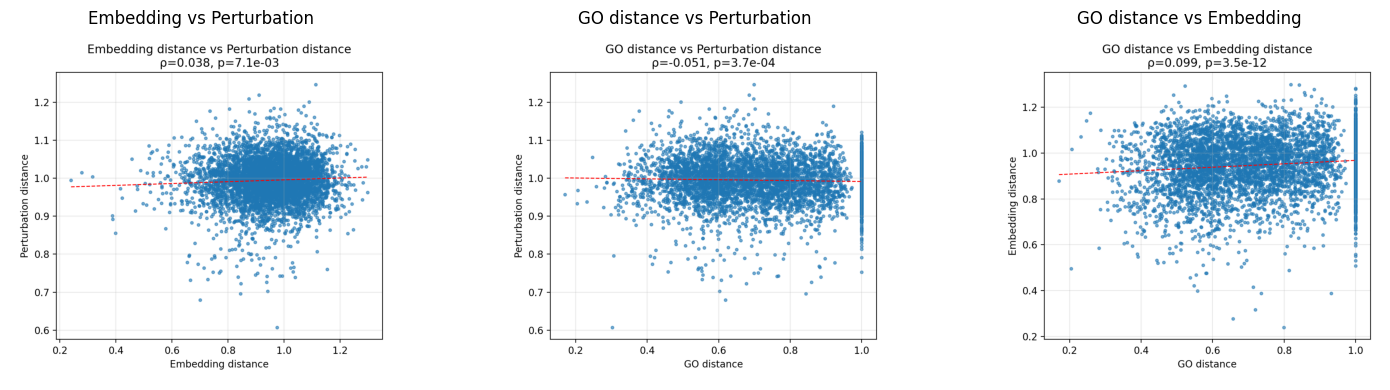

=== GO vs Distances Summary ===
{
  "n_genes": 100,
  "spearman": {
    "emb_vs_eff": {
      "rho": 0.03822974672538873,
      "p": 0.007145092553481106
    },
    "go_vs_eff": {
      "rho": -0.05061863152363917,
      "p": 0.0003670308890289089
    },
    "go_vs_emb": {
      "rho": 0.09864698123781238,
      "p": 3.5094560972318866e-12
    }
  }
}
(from /content/results/go_vs_distances_summary.json)


In [ ]:
# --- Quick viewer for your GO-vs-distance figures and JSON summary ---

from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg  # for imread

def show_go_distance_figs(
    fig_dir="figs",
    json_path="results/go_vs_distances_summary.json",
    files=(
        "go_analysis_emb_vs_eff.png",  # Embedding vs Perturbation
        "go_analysis_go_vs_eff.png",   # GO distance vs Perturbation
        "go_analysis_go_vs_emb.png",   # GO distance vs Embedding
    ),
    titles=(
        "Embedding vs Perturbation",
        "GO distance vs Perturbation",
        "GO distance vs Embedding",
    )
):
    fig_dir = Path(fig_dir)
    fig_paths = [fig_dir / f for f in files]

    # Check which images exist
    exists_mask = [p.exists() for p in fig_paths]
    if not any(exists_mask):
        print(f"No GO figures found in: {fig_dir.resolve()}")
        print("Expected:", *[str(p) for p in fig_paths], sep="\n  - ")
        return

    # Load only the images that exist
    imgs, used_titles = [], []
    for ok, p, t in zip(exists_mask, fig_paths, titles):
        if ok:
            imgs.append(mpimg.imread(str(p)))
            used_titles.append(t)
        else:
            print(f"Missing figure (skipping): {p}")

    # Show in a single row
    n = len(imgs)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 4))
    axes = np.atleast_1d(axes)

    for ax, img, ttl in zip(axes, imgs, used_titles):
        ax.imshow(img)
        ax.set_title(ttl)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

    # Pretty-print JSON summary if present
    jp = Path(json_path)
    if jp.exists():
        with open(jp, "r") as f:
            summary = json.load(f)
        print("=== GO vs Distances Summary ===")
        print(json.dumps(summary, indent=2))
        print(f"(from {jp.resolve()})")
    else:
        print(f"Summary JSON not found at: {jp.resolve()}")

# Run it:
show_go_distance_figs()


In [ ]:
# =========================
# PARTIAL CORRELATION ANALYSIS
# Embeddings vs GO: Who predicts perturbations better?
# =========================

import os, json, gzip, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import scanpy as sc
import scipy.io
from scipy import sparse
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

# GO analysis imports
import mygene
import obonet
import networkx as nx
import urllib.request
import math

# ===================================
# 1. LOAD YOUR COMPLETE PIPELINE DATA
# ===================================

# File paths - update these to your actual paths
BASE = "/content/drive/MyDrive/dataset-gene-embed"
FILES = {
    "barcodes": f"{BASE}/GSE133344_filtered_barcodes.tsv.gz",
    "cell_id": f"{BASE}/GSE133344_filtered_cell_identities.csv.gz",
    "matrix": f"{BASE}/GSE133344_filtered_matrix.mtx",
    "genes": f"{BASE}/GSE133344_filtered_genes.tsv",
    "generain": f"{BASE}/GeneRAIN-vec.200d.txt",
}

def load_gse133344():
    print("Loading GSE133344...")
    genes = pd.read_csv(FILES["genes"], sep="\t", header=None, names=["ensembl_id","gene_symbol"])
    with gzip.open(FILES["barcodes"], "rt") as f:
        barcodes = [ln.strip() for ln in f]
    cell_id = pd.read_csv(FILES["cell_id"], compression="gzip")
    X = scipy.io.mmread(FILES["matrix"]).T.tocsr()

    ad = sc.AnnData(X=X)
    ad.obs_names = barcodes
    ad.var_names = genes["gene_symbol"].values
    ad.var["ensembl_id"] = genes["ensembl_id"].values
    ad.var_names_make_unique()

    cell_id = cell_id.set_index("cell_barcode")
    common = list(set(ad.obs_names) & set(cell_id.index))
    ad = ad[common].copy()
    ad.obs = ad.obs.join(cell_id.loc[common])
    return ad

def parse_combinatorial_targets(guide_identity):
    if pd.isna(guide_identity): return []
    target_part = guide_identity.split('__')[0]
    comps = [c for c in target_part.split('_') if c and 'NegCtrl' not in c]
    seen, out = set(), []
    for g in comps:
        if g not in seen: out.append(g); seen.add(g)
    return out

def categorize_perturbations(ad):
    ad.obs['parsed_targets'] = ad.obs['guide_identity'].apply(parse_combinatorial_targets)
    ad.obs['n_targets'] = ad.obs['parsed_targets'].apply(len)
    ad.obs['perturbation_type'] = 'unknown'
    ad.obs.loc[ad.obs['n_targets'] == 0, 'perturbation_type'] = 'control'
    ad.obs.loc[ad.obs['n_targets'] == 1, 'perturbation_type'] = 'single'
    ad.obs.loc[ad.obs['n_targets'] == 2, 'perturbation_type'] = 'dual'
    ad.obs.loc[ad.obs['n_targets'] > 2, 'perturbation_type'] = 'multi'
    return ad

def load_generain_embeddings(path):
    print(f"Loading GeneRAIN from: {path}")
    genes, embeds = [], []
    with open(path, "r") as f:
        _ = f.readline().strip()
        for ln in f:
            parts = ln.strip().split()
            if len(parts) < 2: continue
            genes.append(parts[0])
            embeds.append([float(x) for x in parts[1:]])
    df = pd.DataFrame(embeds, index=pd.Index(genes, name="gene"))
    df.columns = [f"generain_{i}" for i in range(df.shape[1])]
    df = df[~df.index.duplicated(keep="first")]
    return df

def make_gemgroup_matched_combinatorial_pseudobulk(ad, min_cells=20):
    print("Creating gemgroup-matched pseudobulks...")
    groups = ad.obs.groupby(['guide_identity', 'gemgroup']).indices
    rows, meta = [], []
    X = ad.X
    is_sparse = sparse.issparse(X)
    for (guide, gem), idx in groups.items():
        if len(idx) < min_cells: continue
        summed = np.array(X[idx].sum(axis=0)).ravel() if is_sparse else X[idx].sum(axis=0)
        rows.append(summed)
        meta.append({
            'guide_identity': guide,
            'gemgroup': gem,
            'n_cells': len(idx),
            'targets': ad.obs.loc[ad.obs_names[idx[0]], 'parsed_targets'],
            'perturbation_type': ad.obs.loc[ad.obs_names[idx[0]], 'perturbation_type']
        })
    pb = pd.DataFrame(rows, columns=ad.var_names)
    pb.index = pd.MultiIndex.from_frame(pd.DataFrame(meta)[['guide_identity','gemgroup']])
    meta_df = pd.DataFrame(meta)
    return pb, meta_df

def compute_gemgroup_matched_combinatorial_effects(pseudobulk_df, meta_df):
    print("Computing gemgroup-matched effects...")
    lib = pseudobulk_df.sum(axis=1)
    cpm = pseudobulk_df.div(lib, axis=0) * 1e6
    logcpm = np.log1p(cpm)

    control_guides = set(meta_df[meta_df['perturbation_type']=='control']['guide_identity'])
    all_guides = sorted(set(meta_df['guide_identity']))
    target_guides = [g for g in all_guides if g not in control_guides]

    effects = {}
    for guide in target_guides:
        try:
            gp = logcpm.loc[guide]
            if isinstance(gp, pd.Series):
                gp = pd.DataFrame([gp.values], index=[gp.name], columns=logcpm.columns)
            geffs = []
            for gem in gp.index:
                ctrls = []
                for c in control_guides:
                    try: ctrls.append(logcpm.loc[(c, gem)])
                    except KeyError: pass
                if ctrls:
                    ctrlmean = ctrls[0] if len(ctrls)==1 else pd.concat(ctrls, axis=1).mean(axis=1)
                    geffs.append(gp.loc[gem] - ctrlmean)
            if geffs:
                mean_eff = geffs[0] if len(geffs)==1 else pd.concat(geffs, axis=1).mean(axis=1)
                effects[guide] = mean_eff.values
        except KeyError:
            continue
    eff = pd.DataFrame.from_dict(effects, orient='index', columns=logcpm.columns)
    mu = eff.mean(axis=0); sd = eff.std(axis=0, ddof=0).replace(0, 1.0)
    z = eff.subtract(mu, axis=1).divide(sd, axis=1)
    z = z.replace([np.inf, -np.inf], 0).fillna(0)
    return z

def extract_single_gene_data(effects_df, embeddings_df, guide_list):
    sg_guides, sg_genes = [], []
    for guide in guide_list:
        genes = [g for g in guide.split("__")[0].split("_") if g and "NegCtrl" not in g]
        if len(genes)==1:
            sg_guides.append(guide); sg_genes.append(genes[0])
    if not sg_guides: return None, None, []
    eff_sg = effects_df.loc[sg_guides].copy()
    emb_sg = embeddings_df.loc[sg_guides].copy()
    eff_sg.index = sg_genes; emb_sg.index = sg_genes
    dedup = ~pd.Index(sg_genes).duplicated()
    eff_g = eff_sg.loc[dedup]; emb_g = emb_sg.loc[dedup]
    return eff_g, emb_g, eff_g.index.tolist()

def create_combined_embeddings_multi_method(target_combinations, generain_embeddings, method='average'):
    out, missing = {}, set()
    for combo, genes in target_combinations.items():
        if len(genes)==0:
            out[combo] = np.zeros(generain_embeddings.shape[1])
            continue
        avail = [g for g in genes if g in generain_embeddings.index]
        missing.update(set(genes)-set(avail))
        if not avail: continue
        M = np.stack([generain_embeddings.loc[g].values for g in avail])
        if method=='average': out[combo] = M.mean(axis=0)
        elif method=='sum':  out[combo] = M.sum(axis=0)
        elif method=='hadamard': out[combo] = M.prod(axis=0)
    return pd.DataFrame.from_dict(out, orient='index')

# ===================================
# 2. GO ANALYSIS FUNCTIONS
# ===================================

def load_go_basic_obo(path="go-basic.obo"):
    if not os.path.exists(path):
        url = "http://purl.obolibrary.org/obo/go/go-basic.obo"
        print("Downloading go-basic.obo ...")
        urllib.request.urlretrieve(url, path)
    print("Reading GO graph...")
    return obonet.read_obo(path)

def fetch_gene_go_bp_annotations(genes, species="human", chunk=1000):
    mg = mygene.MyGeneInfo()
    genes = [str(g) for g in genes]
    out = {g: set() for g in genes}

    for i in range(0, len(genes), chunk):
        batch = genes[i:i+chunk]
        resp = mg.querymany(
            batch, scopes="symbol", fields="go.BP", species=species,
            as_dataframe=False, returnall=False, verbose=False
        )
        for rec in resp:
            q = rec.get("query") or rec.get("symbol")
            if not q or q not in out: continue
            go_obj = (rec.get("go") or {})
            bp = go_obj.get("BP")
            if isinstance(bp, list):
                for v in bp:
                    tid = v.get("id") if isinstance(v, dict) else (v if isinstance(v, str) else None)
                    if tid: out[q].add(tid if tid.startswith("GO:") else f"GO:{tid}")
            elif isinstance(bp, dict):
                tid = bp.get("id")
                if tid: out[q].add(tid if tid.startswith("GO:") else f"GO:{tid}")
            elif isinstance(bp, str):
                out[q].add(bp if bp.startswith("GO:") else f"GO:{bp}")
    return out

def compute_ic_resnik(go_dag, gene_to_terms_bp):
    term_counts = {}
    total_assignments = 0
    ancestors_cache = {}

    def ancestors_incl(t):
        if t not in ancestors_cache:
            anc = {t}
            if t in go_dag:
                anc |= nx.ancestors(go_dag, t)
            ancestors_cache[t] = anc
        return ancestors_cache[t]

    for gene, terms in gene_to_terms_bp.items():
        seen = set()
        for t in terms:
            if t not in go_dag: continue
            seen |= ancestors_incl(t)
        for tt in seen:
            term_counts[tt] = term_counts.get(tt, 0) + 1
            total_assignments += 1

    ic = {}
    for t, c in term_counts.items():
        p = c / max(total_assignments, 1)
        ic[t] = -math.log(p) if p > 0 else 0.0
    return ic

def resnik_pair_max_ic(go_dag, ic_map, t1, t2):
    if (t1 not in go_dag) or (t2 not in go_dag): return 0.0
    a1 = nx.ancestors(go_dag, t1) | {t1}
    a2 = nx.ancestors(go_dag, t2) | {t2}
    inter = a1 & a2
    if not inter: return 0.0
    return max(ic_map.get(x, 0.0) for x in inter)

def resnik_bma_for_sets(go_dag, ic_map, setA, setB):
    if not setA or not setB: return 0.0
    s1 = []
    for a in setA:
        mx = 0.0
        for b in setB:
            v = resnik_pair_max_ic(go_dag, ic_map, a, b)
            if v > mx: mx = v
        s1.append(mx)
    s2 = []
    for b in setB:
        mx = 0.0
        for a in setA:
            v = resnik_pair_max_ic(go_dag, ic_map, a, b)
            if v > mx: mx = v
        s2.append(mx)
    return float((np.mean(s1) + np.mean(s2)) / 2.0)

def build_go_similarity_and_distance(genes, gene_to_terms_bp, go_dag, ic_map):
    n = len(genes)
    S = np.zeros((n, n), dtype=float)
    for i in range(n):
        Si = set(gene_to_terms_bp.get(genes[i], set()))
        for j in range(i, n):
            Sj = set(gene_to_terms_bp.get(genes[j], set()))
            sim = resnik_bma_for_sets(go_dag, ic_map, Si, Sj)
            S[i, j] = S[j, i] = sim
    maxS = np.nanmax(S) if np.nanmax(S) > 0 else 1.0
    D_go = 1.0 - (S / maxS)
    np.fill_diagonal(D_go, 0.0)
    return S, D_go

# ===================================
# 3. PARTIAL CORRELATION FUNCTIONS
# ===================================

def partial_correlation_spearman(x, y, z):
    """
    Compute partial Spearman correlation between x and y, controlling for z.
    Uses the formula: r_xy.z = (r_xy - r_xz * r_yz) / sqrt((1 - r_xz^2) * (1 - r_yz^2))
    """
    # Convert to ranks for Spearman
    from scipy.stats import rankdata
    x_ranks = rankdata(x)
    y_ranks = rankdata(y)
    z_ranks = rankdata(z)

    # Compute Pearson correlations on ranks (= Spearman correlations)
    r_xy, _ = pearsonr(x_ranks, y_ranks)
    r_xz, _ = pearsonr(x_ranks, z_ranks)
    r_yz, _ = pearsonr(y_ranks, z_ranks)

    # Partial correlation formula
    numerator = r_xy - r_xz * r_yz
    denominator = np.sqrt((1 - r_xz**2) * (1 - r_yz**2))

    if denominator == 0:
        return 0.0, 1.0

    r_partial = numerator / denominator

    # Approximate p-value using t-distribution
    n = len(x)
    df = n - 3  # degrees of freedom for partial correlation
    if df <= 0:
        return r_partial, 1.0

    t_stat = r_partial * np.sqrt(df / (1 - r_partial**2)) if abs(r_partial) < 1 else float('inf')

    from scipy.stats import t
    p_value = 2 * (1 - t.cdf(abs(t_stat), df))

    return r_partial, p_value

# ===================================
# 4. MAIN ANALYSIS RUNNER
# ===================================

def run_partial_correlation_analysis():
    print("="*60)
    print("PARTIAL CORRELATION ANALYSIS")
    print("Testing if embeddings add info beyond GO annotations")
    print("="*60)

    # 1. Load data and run pipeline
    ad = load_gse133344()
    ad = categorize_perturbations(ad)
    generain = load_generain_embeddings(FILES['generain'])

    pb, meta = make_gemgroup_matched_combinatorial_pseudobulk(ad, min_cells=20)
    effects = compute_gemgroup_matched_combinatorial_effects(pb, meta)

    # 2. Create embeddings for guides
    target_combos = {}
    for _,row in meta.iterrows():
        g = row['guide_identity']
        if g in effects.index: target_combos[g] = row['targets']

    emb = create_combined_embeddings_multi_method(target_combos, generain, method='average')
    common = sorted(set(effects.index) & set(emb.index))
    eff_al = effects.loc[common]; emb_al = emb.loc[common]

    # 3. Extract single-gene subset for analysis
    eff_genes, emb_genes, uniq_genes = extract_single_gene_data(eff_al, emb_al, common)

    if eff_genes is None or len(uniq_genes) < 20:
        print("ERROR: Insufficient single-gene data for analysis")
        return None

    print(f"Analyzing {len(uniq_genes)} single genes")

    # 4. Build distance matrices
    print("Computing distance matrices...")
    D_emb = pairwise_distances(emb_genes.values, metric="cosine")
    D_eff = pairwise_distances(eff_genes.values, metric="cosine")
    np.fill_diagonal(D_emb, 0.0)
    np.fill_diagonal(D_eff, 0.0)

    # 5. Build GO distance matrix
    print("Computing GO similarities...")
    go_dag = load_go_basic_obo()
    gene2bp = fetch_gene_go_bp_annotations(uniq_genes)
    ic = compute_ic_resnik(go_dag, gene2bp)
    S_go, D_go = build_go_similarity_and_distance(uniq_genes, gene2bp, go_dag, ic)

    # 6. Extract upper triangle for correlations
    iu = np.triu_indices(len(uniq_genes), k=1)
    emb_dist = D_emb[iu]
    eff_dist = D_eff[iu]
    go_dist = D_go[iu]

    # 7. Simple correlations (for comparison)
    rho_emb_eff, p_emb_eff = spearmanr(emb_dist, eff_dist)
    rho_go_eff, p_go_eff = spearmanr(go_dist, eff_dist)
    rho_go_emb, p_go_emb = spearmanr(go_dist, emb_dist)

    print("\n=== Simple Correlations ===")
    print(f"Embedding vs Perturbation: ρ = {rho_emb_eff:.3f}, p = {p_emb_eff:.2e}")
    print(f"GO vs Perturbation:        ρ = {rho_go_eff:.3f}, p = {p_go_eff:.2e}")
    print(f"GO vs Embedding:           ρ = {rho_go_emb:.3f}, p = {p_go_emb:.2e}")

    # 8. PARTIAL CORRELATIONS - THE KEY ANALYSIS
    print("\n=== Partial Correlations ===")

    # Embedding vs Perturbation, controlling for GO
    rho_emb_eff_given_go, p_emb_eff_given_go = partial_correlation_spearman(
        emb_dist, eff_dist, go_dist
    )

    # GO vs Perturbation, controlling for Embedding
    rho_go_eff_given_emb, p_go_eff_given_emb = partial_correlation_spearman(
        go_dist, eff_dist, emb_dist
    )

    print(f"Embedding vs Perturbation | GO:  ρ = {rho_emb_eff_given_go:.3f}, p = {p_emb_eff_given_go:.2e}")
    print(f"GO vs Perturbation | Embedding:  ρ = {rho_go_eff_given_emb:.3f}, p = {p_go_eff_given_emb:.2e}")

    # 9. Interpretation
    print("\n=== INTERPRETATION ===")
    if rho_emb_eff_given_go > 0 and p_emb_eff_given_go < 0.05:
        print("✓ Embeddings retain predictive power after controlling for GO")
    else:
        print("✗ Embeddings lose predictive power after controlling for GO")

    if abs(rho_go_eff_given_emb) < 0.02 or p_go_eff_given_emb > 0.05:
        print("✓ GO annotations have little/no predictive power after controlling for embeddings")
    else:
        print("✗ GO annotations retain predictive power after controlling for embeddings")

    # 10. Save results
    results = {
        "n_genes": len(uniq_genes),
        "simple_correlations": {
            "embedding_vs_perturbation": {"rho": float(rho_emb_eff), "p": float(p_emb_eff)},
            "go_vs_perturbation": {"rho": float(rho_go_eff), "p": float(p_go_eff)},
            "go_vs_embedding": {"rho": float(rho_go_emb), "p": float(p_go_emb)}
        },
        "partial_correlations": {
            "embedding_vs_perturbation_given_go": {
                "rho": float(rho_emb_eff_given_go),
                "p": float(p_emb_eff_given_go)
            },
            "go_vs_perturbation_given_embedding": {
                "rho": float(rho_go_eff_given_emb),
                "p": float(p_go_eff_given_emb)
            }
        }
    }

    os.makedirs("results", exist_ok=True)
    with open("results/partial_correlation_analysis.json", "w") as f:
        json.dump(results, f, indent=2)

    print(f"\nSaved results to: results/partial_correlation_analysis.json")
    return results

# ===================================
# 5. RUN THE ANALYSIS
# ===================================

if __name__ == "__main__":
    results = run_partial_correlation_analysis()

PARTIAL CORRELATION ANALYSIS
Testing if embeddings add info beyond GO annotations
Loading GSE133344...
Loading GeneRAIN from: /content/drive/MyDrive/dataset-gene-embed/GeneRAIN-vec.200d.txt
Creating gemgroup-matched pseudobulks...
Computing gemgroup-matched effects...
Analyzing 100 single genes
Computing distance matrices...
Computing GO similarities...
Reading GO graph...


In [ ]:
# =========================
# PERMUTATION TESTS & MULTIPLE REGRESSION ON DISTANCE MATRICES
# Robust statistical validation of embedding vs GO predictive power
# =========================

import os, json, gzip, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import scanpy as sc
import scipy.io
from scipy import sparse
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# GO analysis imports
import mygene
import obonet
import networkx as nx
import urllib.request
import math
from skbio.stats.distance import mantel

# ===================================
# 1. COMPLETE DATA LOADING PIPELINE
# ===================================

BASE = "/content/drive/MyDrive/dataset-gene-embed"
FILES = {
    "barcodes": f"{BASE}/GSE133344_filtered_barcodes.tsv.gz",
    "cell_id": f"{BASE}/GSE133344_filtered_cell_identities.csv.gz",
    "matrix": f"{BASE}/GSE133344_filtered_matrix.mtx",
    "genes": f"{BASE}/GSE133344_filtered_genes.tsv",
    "generain": f"{BASE}/GeneRAIN-vec.200d.txt",
}

def load_gse133344():
    print("Loading GSE133344...")
    genes = pd.read_csv(FILES["genes"], sep="\t", header=None, names=["ensembl_id","gene_symbol"])
    with gzip.open(FILES["barcodes"], "rt") as f:
        barcodes = [ln.strip() for ln in f]
    cell_id = pd.read_csv(FILES["cell_id"], compression="gzip")
    X = scipy.io.mmread(FILES["matrix"]).T.tocsr()

    ad = sc.AnnData(X=X)
    ad.obs_names = barcodes
    ad.var_names = genes["gene_symbol"].values
    ad.var["ensembl_id"] = genes["ensembl_id"].values
    ad.var_names_make_unique()

    cell_id = cell_id.set_index("cell_barcode")
    common = list(set(ad.obs_names) & set(cell_id.index))
    ad = ad[common].copy()
    ad.obs = ad.obs.join(cell_id.loc[common])
    return ad

def parse_combinatorial_targets(guide_identity):
    if pd.isna(guide_identity): return []
    target_part = guide_identity.split('__')[0]
    comps = [c for c in target_part.split('_') if c and 'NegCtrl' not in c]
    seen, out = set(), []
    for g in comps:
        if g not in seen: out.append(g); seen.add(g)
    return out

def categorize_perturbations(ad):
    ad.obs['parsed_targets'] = ad.obs['guide_identity'].apply(parse_combinatorial_targets)
    ad.obs['n_targets'] = ad.obs['parsed_targets'].apply(len)
    ad.obs['perturbation_type'] = 'unknown'
    ad.obs.loc[ad.obs['n_targets'] == 0, 'perturbation_type'] = 'control'
    ad.obs.loc[ad.obs['n_targets'] == 1, 'perturbation_type'] = 'single'
    ad.obs.loc[ad.obs['n_targets'] == 2, 'perturbation_type'] = 'dual'
    ad.obs.loc[ad.obs['n_targets'] > 2, 'perturbation_type'] = 'multi'
    return ad

def load_generain_embeddings(path):
    print(f"Loading GeneRAIN from: {path}")
    genes, embeds = [], []
    with open(path, "r") as f:
        _ = f.readline().strip()
        for ln in f:
            parts = ln.strip().split()
            if len(parts) < 2: continue
            genes.append(parts[0])
            embeds.append([float(x) for x in parts[1:]])
    df = pd.DataFrame(embeds, index=pd.Index(genes, name="gene"))
    df.columns = [f"generain_{i}" for i in range(df.shape[1])]
    df = df[~df.index.duplicated(keep="first")]
    return df

def make_gemgroup_matched_combinatorial_pseudobulk(ad, min_cells=20):
    print("Creating gemgroup-matched pseudobulks...")
    groups = ad.obs.groupby(['guide_identity', 'gemgroup']).indices
    rows, meta = [], []
    X = ad.X
    is_sparse = sparse.issparse(X)
    for (guide, gem), idx in groups.items():
        if len(idx) < min_cells: continue
        summed = np.array(X[idx].sum(axis=0)).ravel() if is_sparse else X[idx].sum(axis=0)
        rows.append(summed)
        meta.append({
            'guide_identity': guide,
            'gemgroup': gem,
            'n_cells': len(idx),
            'targets': ad.obs.loc[ad.obs_names[idx[0]], 'parsed_targets'],
            'perturbation_type': ad.obs.loc[ad.obs_names[idx[0]], 'perturbation_type']
        })
    pb = pd.DataFrame(rows, columns=ad.var_names)
    pb.index = pd.MultiIndex.from_frame(pd.DataFrame(meta)[['guide_identity','gemgroup']])
    meta_df = pd.DataFrame(meta)
    return pb, meta_df

def compute_gemgroup_matched_combinatorial_effects(pseudobulk_df, meta_df):
    print("Computing gemgroup-matched effects...")
    lib = pseudobulk_df.sum(axis=1)
    cpm = pseudobulk_df.div(lib, axis=0) * 1e6
    logcpm = np.log1p(cpm)

    control_guides = set(meta_df[meta_df['perturbation_type']=='control']['guide_identity'])
    all_guides = sorted(set(meta_df['guide_identity']))
    target_guides = [g for g in all_guides if g not in control_guides]

    effects = {}
    for guide in target_guides:
        try:
            gp = logcpm.loc[guide]
            if isinstance(gp, pd.Series):
                gp = pd.DataFrame([gp.values], index=[gp.name], columns=logcpm.columns)
            geffs = []
            for gem in gp.index:
                ctrls = []
                for c in control_guides:
                    try: ctrls.append(logcpm.loc[(c, gem)])
                    except KeyError: pass
                if ctrls:
                    ctrlmean = ctrls[0] if len(ctrls)==1 else pd.concat(ctrls, axis=1).mean(axis=1)
                    geffs.append(gp.loc[gem] - ctrlmean)
            if geffs:
                mean_eff = geffs[0] if len(geffs)==1 else pd.concat(geffs, axis=1).mean(axis=1)
                effects[guide] = mean_eff.values
        except KeyError:
            continue
    eff = pd.DataFrame.from_dict(effects, orient='index', columns=logcpm.columns)
    mu = eff.mean(axis=0); sd = eff.std(axis=0, ddof=0).replace(0, 1.0)
    z = eff.subtract(mu, axis=1).divide(sd, axis=1)
    z = z.replace([np.inf, -np.inf], 0).fillna(0)
    return z

def extract_single_gene_data(effects_df, embeddings_df, guide_list):
    sg_guides, sg_genes = [], []
    for guide in guide_list:
        genes = [g for g in guide.split("__")[0].split("_") if g and "NegCtrl" not in g]
        if len(genes)==1:
            sg_guides.append(guide); sg_genes.append(genes[0])
    if not sg_guides: return None, None, []
    eff_sg = effects_df.loc[sg_guides].copy()
    emb_sg = embeddings_df.loc[sg_guides].copy()
    eff_sg.index = sg_genes; emb_sg.index = sg_genes
    dedup = ~pd.Index(sg_genes).duplicated()
    eff_g = eff_sg.loc[dedup]; emb_g = emb_sg.loc[dedup]
    return eff_g, emb_g, eff_g.index.tolist()

def create_combined_embeddings_multi_method(target_combinations, generain_embeddings, method='average'):
    out, missing = {}, set()
    for combo, genes in target_combinations.items():
        if len(genes)==0:
            out[combo] = np.zeros(generain_embeddings.shape[1])
            continue
        avail = [g for g in genes if g in generain_embeddings.index]
        missing.update(set(genes)-set(avail))
        if not avail: continue
        M = np.stack([generain_embeddings.loc[g].values for g in avail])
        if method=='average': out[combo] = M.mean(axis=0)
        elif method=='sum':  out[combo] = M.sum(axis=0)
        elif method=='hadamard': out[combo] = M.prod(axis=0)
    return pd.DataFrame.from_dict(out, orient='index')

# ===================================
# 2. GO ANALYSIS FUNCTIONS
# ===================================

def load_go_basic_obo(path="go-basic.obo"):
    if not os.path.exists(path):
        url = "http://purl.obolibrary.org/obo/go/go-basic.obo"
        print("Downloading go-basic.obo ...")
        urllib.request.urlretrieve(url, path)
    print("Reading GO graph...")
    return obonet.read_obo(path)

def fetch_gene_go_bp_annotations(genes, species="human", chunk=1000):
    mg = mygene.MyGeneInfo()
    genes = [str(g) for g in genes]
    out = {g: set() for g in genes}

    for i in range(0, len(genes), chunk):
        batch = genes[i:i+chunk]
        resp = mg.querymany(
            batch, scopes="symbol", fields="go.BP", species=species,
            as_dataframe=False, returnall=False, verbose=False
        )
        for rec in resp:
            q = rec.get("query") or rec.get("symbol")
            if not q or q not in out: continue
            go_obj = (rec.get("go") or {})
            bp = go_obj.get("BP")
            if isinstance(bp, list):
                for v in bp:
                    tid = v.get("id") if isinstance(v, dict) else (v if isinstance(v, str) else None)
                    if tid: out[q].add(tid if tid.startswith("GO:") else f"GO:{tid}")
            elif isinstance(bp, dict):
                tid = bp.get("id")
                if tid: out[q].add(tid if tid.startswith("GO:") else f"GO:{tid}")
            elif isinstance(bp, str):
                out[q].add(bp if bp.startswith("GO:") else f"GO:{bp}")
    return out

def compute_ic_resnik(go_dag, gene_to_terms_bp):
    term_counts = {}
    total_assignments = 0
    ancestors_cache = {}

    def ancestors_incl(t):
        if t not in ancestors_cache:
            anc = {t}
            if t in go_dag:
                anc |= nx.ancestors(go_dag, t)
            ancestors_cache[t] = anc
        return ancestors_cache[t]

    for gene, terms in gene_to_terms_bp.items():
        seen = set()
        for t in terms:
            if t not in go_dag: continue
            seen |= ancestors_incl(t)
        for tt in seen:
            term_counts[tt] = term_counts.get(tt, 0) + 1
            total_assignments += 1

    ic = {}
    for t, c in term_counts.items():
        p = c / max(total_assignments, 1)
        ic[t] = -math.log(p) if p > 0 else 0.0
    return ic

def resnik_pair_max_ic(go_dag, ic_map, t1, t2):
    if (t1 not in go_dag) or (t2 not in go_dag): return 0.0
    a1 = nx.ancestors(go_dag, t1) | {t1}
    a2 = nx.ancestors(go_dag, t2) | {t2}
    inter = a1 & a2
    if not inter: return 0.0
    return max(ic_map.get(x, 0.0) for x in inter)

def resnik_bma_for_sets(go_dag, ic_map, setA, setB):
    if not setA or not setB: return 0.0
    s1 = []
    for a in setA:
        mx = 0.0
        for b in setB:
            v = resnik_pair_max_ic(go_dag, ic_map, a, b)
            if v > mx: mx = v
        s1.append(mx)
    s2 = []
    for b in setB:
        mx = 0.0
        for a in setA:
            v = resnik_pair_max_ic(go_dag, ic_map, a, b)
            if v > mx: mx = v
        s2.append(mx)
    return float((np.mean(s1) + np.mean(s2)) / 2.0)

def build_go_similarity_and_distance(genes, gene_to_terms_bp, go_dag, ic_map):
    n = len(genes)
    S = np.zeros((n, n), dtype=float)
    for i in range(n):
        Si = set(gene_to_terms_bp.get(genes[i], set()))
        for j in range(i, n):
            Sj = set(gene_to_terms_bp.get(genes[j], set()))
            sim = resnik_bma_for_sets(go_dag, ic_map, Si, Sj)
            S[i, j] = S[j, i] = sim
    maxS = np.nanmax(S) if np.nanmax(S) > 0 else 1.0
    D_go = 1.0 - (S / maxS)
    np.fill_diagonal(D_go, 0.0)
    return S, D_go

# ===================================
# 3. PERMUTATION TEST FUNCTIONS
# ===================================

def permutation_correlation_test(x, y, n_permutations=10000, random_state=42):
    """
    Permutation test for correlation between two vectors.
    Returns observed correlation and permutation p-value.
    """
    # Observed correlation
    obs_corr, _ = spearmanr(x, y)

    # Permutation test
    rng = np.random.default_rng(random_state)
    null_corrs = []

    for i in range(n_permutations):
        # Permute one of the vectors
        y_perm = rng.permutation(y)
        perm_corr, _ = spearmanr(x, y_perm)
        if not np.isnan(perm_corr):
            null_corrs.append(perm_corr)

    # Calculate p-value (two-tailed)
    null_corrs = np.array(null_corrs)
    p_value = np.mean(np.abs(null_corrs) >= np.abs(obs_corr))

    return obs_corr, p_value, null_corrs

def distance_matrix_permutation_test(D1, D2, n_permutations=10000, random_state=42):
    """
    Permutation test for correlation between distance matrices.
    Permutes row/column labels of one matrix.
    """
    # Extract upper triangles
    iu = np.triu_indices_from(D1, k=1)
    x, y = D1[iu], D2[iu]

    # Remove invalid values
    valid = ~(np.isnan(x) | np.isnan(y) | np.isinf(x) | np.isinf(y))
    x, y = x[valid], y[valid]

    if len(x) == 0:
        return 0.0, 1.0, []

    # Observed correlation
    obs_corr, _ = spearmanr(x, y)

    # Permutation test
    rng = np.random.default_rng(random_state)
    null_corrs = []
    n = D1.shape[0]

    for i in range(n_permutations):
        # Permute rows and columns of D2
        perm_idx = rng.permutation(n)
        D2_perm = D2[perm_idx][:, perm_idx]

        # Extract upper triangle of permuted matrix
        y_perm = D2_perm[iu]
        y_perm_valid = y_perm[valid]

        perm_corr, _ = spearmanr(x, y_perm_valid)
        if not np.isnan(perm_corr):
            null_corrs.append(perm_corr)

    # Calculate p-value (two-tailed)
    null_corrs = np.array(null_corrs)
    p_value = np.mean(np.abs(null_corrs) >= np.abs(obs_corr))

    return obs_corr, p_value, null_corrs

# ===================================
# 4. MULTIPLE REGRESSION ON DISTANCE MATRICES (MRM)
# ===================================

def multiple_regression_distance_matrices(D_response, D_pred1, D_pred2, n_permutations=10000, random_state=42):
    """
    Multiple regression on distance matrices: D_response ~ D_pred1 + D_pred2
    With permutation test for significance of each predictor.
    """
    # Extract upper triangles
    iu = np.triu_indices_from(D_response, k=1)
    y = D_response[iu]
    x1 = D_pred1[iu]
    x2 = D_pred2[iu]

    # Remove invalid values
    valid = ~(np.isnan(y) | np.isnan(x1) | np.isnan(x2) |
              np.isinf(y) | np.isinf(x1) | np.isinf(x2))
    y, x1, x2 = y[valid], x1[valid], x2[valid]

    if len(y) == 0:
        return {"error": "No valid data points"}

    # Prepare design matrix
    X = np.column_stack([x1, x2])

    # Fit full model
    model = LinearRegression().fit(X, y)
    r2_full = model.score(X, y)
    coefs = model.coef_

    # Fit reduced models to get individual contributions
    model1 = LinearRegression().fit(x1.reshape(-1, 1), y)
    r2_x1_only = model1.score(x1.reshape(-1, 1), y)

    model2 = LinearRegression().fit(x2.reshape(-1, 1), y)
    r2_x2_only = model2.score(x2.reshape(-1, 1), y)

    # Calculate partial R² (unique contribution of each predictor)
    # R²(x1|x2) = R²(full) - R²(x2 only)
    # R²(x2|x1) = R²(full) - R²(x1 only)
    partial_r2_x1 = r2_full - r2_x2_only
    partial_r2_x2 = r2_full - r2_x1_only

    print(f"MRM Results:")
    print(f"  Full model R² = {r2_full:.4f}")
    print(f"  X1 (emb) only R² = {r2_x1_only:.4f}")
    print(f"  X2 (GO) only R² = {r2_x2_only:.4f}")
    print(f"  Partial R² X1|X2 = {partial_r2_x1:.4f}")
    print(f"  Partial R² X2|X1 = {partial_r2_x2:.4f}")

    # Permutation tests for each predictor
    rng = np.random.default_rng(random_state)
    n = D_response.shape[0]

    # Test significance of X1 (embeddings)
    null_partial_r2_x1 = []
    for i in range(n_permutations):
        # Permute D_pred1
        perm_idx = rng.permutation(n)
        D_pred1_perm = D_pred1[perm_idx][:, perm_idx]
        x1_perm = D_pred1_perm[iu][valid]

        # Fit models
        X_perm = np.column_stack([x1_perm, x2])
        model_full_perm = LinearRegression().fit(X_perm, y)
        r2_full_perm = model_full_perm.score(X_perm, y)

        partial_r2_x1_perm = r2_full_perm - r2_x2_only
        null_partial_r2_x1.append(partial_r2_x1_perm)

    p_value_x1 = np.mean(np.array(null_partial_r2_x1) >= partial_r2_x1)

    # Test significance of X2 (GO)
    null_partial_r2_x2 = []
    for i in range(n_permutations):
        # Permute D_pred2
        perm_idx = rng.permutation(n)
        D_pred2_perm = D_pred2[perm_idx][:, perm_idx]
        x2_perm = D_pred2_perm[iu][valid]

        # Fit models
        X_perm = np.column_stack([x1, x2_perm])
        model_full_perm = LinearRegression().fit(X_perm, y)
        r2_full_perm = model_full_perm.score(X_perm, y)

        partial_r2_x2_perm = r2_full_perm - r2_x1_only
        null_partial_r2_x2.append(partial_r2_x2_perm)

    p_value_x2 = np.mean(np.array(null_partial_r2_x2) >= partial_r2_x2)

    return {
        "r2_full": r2_full,
        "r2_x1_only": r2_x1_only,
        "r2_x2_only": r2_x2_only,
        "partial_r2_x1": partial_r2_x1,
        "partial_r2_x2": partial_r2_x2,
        "p_value_x1": p_value_x1,
        "p_value_x2": p_value_x2,
        "coefficients": coefs.tolist(),
        "null_partial_r2_x1": null_partial_r2_x1,
        "null_partial_r2_x2": null_partial_r2_x2
    }

# ===================================
# 5. MAIN ANALYSIS RUNNER
# ===================================

def run_permutation_and_mrm_analysis():
    print("="*80)
    print("PERMUTATION TESTS & MULTIPLE REGRESSION ON DISTANCE MATRICES")
    print("Robust statistical validation addressing non-independence")
    print("="*80)

    # 1. Load data and run pipeline
    ad = load_gse133344()
    ad = categorize_perturbations(ad)
    generain = load_generain_embeddings(FILES['generain'])

    pb, meta = make_gemgroup_matched_combinatorial_pseudobulk(ad, min_cells=20)
    effects = compute_gemgroup_matched_combinatorial_effects(pb, meta)

    # 2. Create embeddings for guides
    target_combos = {}
    for _,row in meta.iterrows():
        g = row['guide_identity']
        if g in effects.index: target_combos[g] = row['targets']

    emb = create_combined_embeddings_multi_method(target_combos, generain, method='average')
    common = sorted(set(effects.index) & set(emb.index))
    eff_al = effects.loc[common]; emb_al = emb.loc[common]

    # 3. Extract single-gene subset for analysis
    eff_genes, emb_genes, uniq_genes = extract_single_gene_data(eff_al, emb_al, common)

    if eff_genes is None or len(uniq_genes) < 20:
        print("ERROR: Insufficient single-gene data for analysis")
        return None

    print(f"Analyzing {len(uniq_genes)} single genes")

    # 4. Build distance matrices
    print("Computing distance matrices...")
    D_emb = pairwise_distances(emb_genes.values, metric="cosine")
    D_eff = pairwise_distances(eff_genes.values, metric="cosine")
    np.fill_diagonal(D_emb, 0.0)
    np.fill_diagonal(D_eff, 0.0)

    # 5. Build GO distance matrix
    print("Computing GO similarities...")
    go_dag = load_go_basic_obo()
    gene2bp = fetch_gene_go_bp_annotations(uniq_genes)
    ic = compute_ic_resnik(go_dag, gene2bp)
    S_go, D_go = build_go_similarity_and_distance(uniq_genes, gene2bp, go_dag, ic)

    # 6. Run permutation tests for individual correlations
    print("\n" + "="*50)
    print("PERMUTATION TESTS FOR INDIVIDUAL CORRELATIONS")
    print("="*50)

    # Test Embedding vs Perturbation
    print("Testing Embedding vs Perturbation correlation...")
    corr_emb_eff, p_emb_eff, null_emb_eff = distance_matrix_permutation_test(
        D_emb, D_eff, n_permutations=10000, random_state=42
    )

    # Test GO vs Perturbation
    print("Testing GO vs Perturbation correlation...")
    corr_go_eff, p_go_eff, null_go_eff = distance_matrix_permutation_test(
        D_go, D_eff, n_permutations=10000, random_state=42
    )

    # Test GO vs Embedding
    print("Testing GO vs Embedding correlation...")
    corr_go_emb, p_go_emb, null_go_emb = distance_matrix_permutation_test(
        D_go, D_emb, n_permutations=10000, random_state=42
    )

    print(f"\nPermutation Test Results:")
    print(f"  Embedding vs Perturbation: ρ = {corr_emb_eff:.3f}, p_perm = {p_emb_eff:.4f}")
    print(f"  GO vs Perturbation:        ρ = {corr_go_eff:.3f}, p_perm = {p_go_eff:.4f}")
    print(f"  GO vs Embedding:           ρ = {corr_go_emb:.3f}, p_perm = {p_go_emb:.4f}")

    # 7. Run Multiple Regression on Distance Matrices
    print("\n" + "="*50)
    print("MULTIPLE REGRESSION ON DISTANCE MATRICES")
    print("Model: D_perturbation ~ D_embedding + D_GO")
    print("="*50)

    mrm_results = multiple_regression_distance_matrices(
        D_eff, D_emb, D_go, n_permutations=5000, random_state=42
    )

    print(f"\nMRM Permutation Test Results:")
    print(f"  Embedding unique contribution: ΔR² = {mrm_results['partial_r2_x1']:.4f}, p = {mrm_results['p_value_x1']:.4f}")
    print(f"  GO unique contribution:        ΔR² = {mrm_results['partial_r2_x2']:.4f}, p = {mrm_results['p_value_x2']:.4f}")

    # 8. Interpretation
    print("\n" + "="*50)
    print("STATISTICAL INTERPRETATION")
    print("="*50)

    if mrm_results['p_value_x1'] < 0.05:
        print("✓ Embeddings provide significant unique predictive information")
    else:
        print("✗ Embeddings do not provide significant unique predictive information")

    if mrm_results['p_value_x2'] < 0.05:
        if mrm_results['partial_r2_x2'] > 0:
            print("✗ GO annotations retain significant positive predictive power")
        else:
            print("! GO annotations have significant negative predictive power")
    else:
        print("✓ GO annotations provide no significant unique predictive information")

    # 9. Save comprehensive results
    results = {
        "n_genes": len(uniq_genes),
        "permutation_tests": {
            "embedding_vs_perturbation": {
                "correlation": float(corr_emb_eff),
                "p_permutation": float(p_emb_eff)
            },
            "go_vs_perturbation": {
                "correlation": float(corr_go_eff),
                "p_permutation": float(p_go_eff)
            },
            "go_vs_embedding": {
                "correlation": float(corr_go_emb),
                "p_permutation": float(p_go_emb)
            }
        },
        "multiple_regression": {
            "full_r2": float(mrm_results['r2_full']),
            "embedding_only_r2": float(mrm_results['r2_x1_only']),
            "go_only_r2": float(mrm_results['r2_x2_only']),
            "embedding_unique_r2": float(mrm_results['partial_r2_x1']),
            "go_unique_r2": float(mrm_results['partial_r2_x2']),
            "embedding_p_value": float(mrm_results['p_value_x1']),
            "go_p_value": float(mrm_results['p_value_x2'])
        }
    }

    os.makedirs("results", exist_ok=True)
    with open("results/permutation_mrm_analysis.json", "w") as f:
        json.dump(results, f, indent=2)

    print(f"\nSaved results to: results/permutation_mrm_analysis.json")

    return results, {
        "D_emb": D_emb,
        "D_eff": D_eff,
        "D_go": D_go,
        "genes": uniq_genes,
        "mrm_results": mrm_results
    }

# ===================================
# 6. RUN THE ANALYSIS
# ===================================

if __name__ == "__main__":
    results, data = run_permutation_and_mrm_analysis()